## Introduction and set up

In [6]:
# !pip install kaggle
# !pip install sympy
# mv kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [7]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

## Prep the data

In [9]:
df = pd.read_csv(path/'train.csv')
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [10]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==1
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master")).value_counts(dropna=False)

add_features(df)

In [11]:
splits = RandomSplitter(seed=42)(df)

In [12]:
splits

((#713) [788,525,821,253,374,98,215,313,281,305...],
 (#178) [303,778,531,385,134,476,691,443,386,128...])

In [13]:
# create dataset
dls = TabularPandas(
    df, 
    splits=splits,
    procs = [Categorify, FillMissing, Normalize], # preprocess
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"], # cat vars
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'], # cont vars
    y_names="Survived", # target
    y_block = CategoryBlock(), # target type
).dataloaders(path=".")

## Train the model

In [15]:
# contains model and layer
# two hidden lsyers
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.0691830962896347, valley=0.010964781977236271)

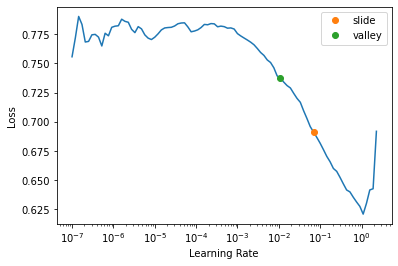

In [17]:
# suggest lr
# starts small, and calculates loss
# pick one between slide and valley
learn.lr_find(suggest_funcs=(slide, valley))

In [18]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.596908,0.555800,0.696629,00:00
1,0.527299,0.421519,0.848315,00:00
2,0.492745,0.427646,0.820225,00:00
3,0.469791,0.432448,0.803371,00:00
4,0.453974,0.418408,0.820225,00:00
5,0.440943,0.436000,0.820225,00:00
6,0.433629,0.451111,0.797753,00:00
7,0.425050,0.393810,0.842697,00:00
8,0.418425,0.434670,0.837079,00:00
9,0.414232,0.419078,0.803371,00:00


## Submit to Kaggle

In [19]:
tst_df = pd.read_csv(path/'test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

In [20]:
# create dataloader that has same preprocess steps as train
tst_dl = learn.dls.test_dl(tst_df)

In [21]:
preds,_ = learn.get_preds(dl=tst_dl)

In [22]:
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [23]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Ensembling
Create multiple models and comnbine

In [25]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    
    with learn.no_bar(),learn.no_logging(): 
        learn.fit(16, lr=0.03)
    
    return learn.get_preds(dl=tst_dl)[0]

In [29]:
learns = [ensemble() for _ in range(5)] # do five models

In [27]:
ens_preds = torch.stack(learns).mean(0) # get the avg prediction

In [28]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)

In [30]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Final thoughts